In [2]:
library(tidyverse)
ggplot2::theme_set(theme_bw())
setwd("C:/Users/이찬솔/Documents/ADP/problem/problem3")

In [3]:
library(showtext)
font_add_google(name = "Black Han Sans", family = "blackhansans")
showtext_auto()

Loading required package: sysfonts

Loading required package: showtextdb



# 1번 
데이터 출처 : https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv 일부 전처리    
데이터 경로 : /kaggle/input/adp-kr-p3/problem1.csv     
데이터 설명 : 집과 관련된 여러 수치들과 집의 가격, log1p 정규화된 price 컬럼 예측 하기 

In [4]:
data1 <- read.csv("problem1.csv")

### 1-1 EDA 및 데이터 전처리
시각화 및 통계량 제시

In [5]:
data11 <- data1 %>%
    mutate(LotFrontage = ifelse(is.na(LotFrontage), 0, LotFrontage )) %>%
    select(-Id)

In [ ]:
# data1 %>% summary
p1 <- data1 %>% ggplot(aes(x = price)) + geom_histogram() 
p2 <- data1 %>% ggplot(aes(YearBuilt, price)) + geom_point() + 
    geom_smooth(se = F)
p3 <- data1 %>% ggplot(aes(YearRemodAdd, price)) + geom_point() + 
    geom_smooth(se = F)
p4 <- visdat::vis_miss(data1, cluster = F)

gridExtra::grid.arrange(grobs = list(p1, p2, p3, p4), nrow = 2)

In [9]:
library("PerformanceAnalytics")

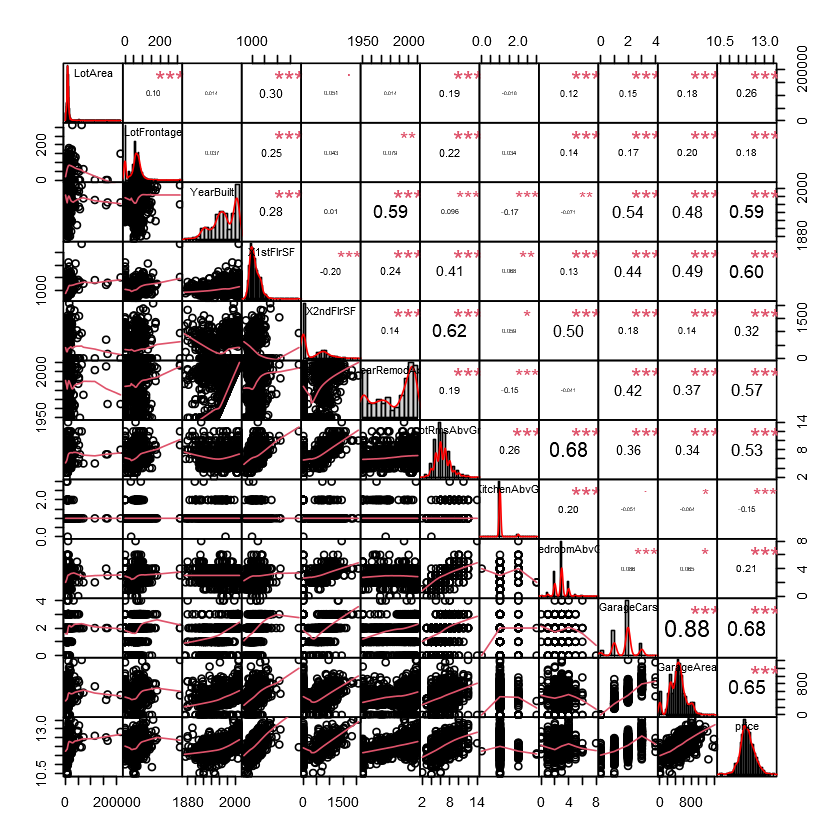

In [38]:
data11 %>% 
    chart.Correlation(histogram = , pch = "+")

### 1-2  Train,Valid,Test set으로 분할 

In [6]:
library(rsample)

In [7]:
set.seed(1234)
split <- initial_split(data11, prop = 0.7)
train <- training(split) ; test <- testing(split)

In [9]:
library(caret)

In [33]:
cv_folds <- caret::createFolds(train$price, k = 10)

### 1-3  2차 교호작용항 까지 고려한 회귀분석 수행 및 변수 선택 과정 제시

In [7]:
train.mat <- model.matrix(price ~ .^3, data = train)[, -1] %>% data.frame %>%
    mutate(price = train$price)
valid.mat <- model.matrix(price ~ .^3, data = valid)[, -1] %>% data.frame %>%
    mutate(price = valid$price)
test.mat <- model.matrix(price ~ .^3, data = test)[, -1] %>% data.frame %>%
    mutate(price = test$price)

In [8]:
lm.full <- lm(price ~ ., data = data.frame(train.mat))

In [9]:
full <- summary(lm.full) 

- F-검정 통계량 검정 결과 => P-value < 0.05 => 모형이 유의함

In [10]:
full$r.squared
full$fstatistic

[1] 0.9211313

value     numdf     dendf 
 28.05216 214.00000 514.00000

In [12]:
library(lmtest)

In [13]:
dwtest(lm.full)


	Durbin-Watson test

data:  lm.full
DW = 1.9838, p-value = 0.7706
alternative hypothesis: true autocorrelation is greater than 0


In [14]:
shapiro.test(resid(lm.full))


	Shapiro-Wilk normality test

data:  resid(lm.full)
W = 0.96665, p-value = 7.803e-12


- 잔차의 독립성, 정규성 만족 X

In [15]:
full.pred <- predict(lm.full, newdata = test.mat)
MLmetrics::MSE(full.pred, test.mat$price)

Warning message in predict.lm(lm.full, newdata = test.mat):
"prediction from a rank-deficient fit may be misleading"


[1] 0.207836

1. 분산이 0에 근사한 변수 제거
2. 단계적 변수 선택법을 통하여 BIC값을 기준으로 변수 선택
3. K-fold CV, 혹은 분할한 Valid/Test dataset을 사용하여, 교차 검증을 통한 변수 선택
- 변수 선택 개수별 모형생성 => Vlid/Test 데이터를 사용하여 모형별 MSE 등의 평가 지표 계산 => 가장 낮은 평가 지표 값을 가지는 모형 및 모형의 변수들을 선택

In [ ]:
caret::nearZeroVar(train.mat, saveMetrics = TRUE) %>%
    tibble::rownames_to_column() %>%
    filter(nzv)

In [ ]:
lm.step <- lm.full %>% step
step <- summary(lm.step)
step$r.squared
step$fstatistic
step.pred <- predict(lm.step, newdata = test.mat)
MLmetrics::MSE(step.pred, test.mat$price)

### 1-4 벌점, 앙상블을 포함하여 모형에 적합한 기계학습 모델 3가지를 제시하라
(평가지표는 MSE, MAPE, R2 모두 확인할 것)

In [10]:
library(caret)

In [12]:
library(recipes)

In [17]:
train_rec <- recipe( ~., data = train) %>%
    step_rm(price) %>%
    step_nzv(all_nominal()) %>%
    step_center(all_numeric()) %>%
    step_scale(all_numeric()) %>%
    prep(training = train, retain = TRUE) %>%
    juice() %>%
    mutate(price = train$price)

test_rec <- recipe( ~., data = test) %>%
    step_rm(price) %>%
    step_nzv(all_nominal()) %>%
    step_center(all_numeric()) %>%
    step_scale(all_numeric()) %>%
    prep(training = test, retain = TRUE) %>%
    juice() %>%
    mutate(price = test$price)

- 벌점

In [18]:
library(glmnet)

In [16]:
train_y <- train_rec$price
train_x <- model.matrix(price ~ ., train_rec)[, -1]
test_y <- test_rec$price
test_x <- model.matrix(price ~ ., test_rec)[, -1]

In [40]:
glm_grid <- expand.grid(
    alpha = seq(0, 1, 0.1),
    lambda = 10^seq(3, -2, length = 10)
)

In [41]:
cv_glmnet <- train(
    x = train_x,
    y = train_y,
    method = "glmnet",
    trControl = trainControl(method = "cv", number = 10,
                             index = cv_folds),
    tuneGrid = glm_grid
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


In [42]:
cv_glmnet$bestTune

,alpha,lambda
,<dbl>,<dbl>
51,0.5,0.01


In [43]:
cv_glmnet$results %>%
    filter(alpha == cv_glmnet$bestTune$alpha,
           lambda == cv_glmnet$bestTune$lambda)

alpha,lambda,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5,0.01,0.1889278,0.7803647,0.1291656,0.04507291,0.09383771,0.01193448


In [44]:
cv_final <- glmnet(x = train_x, y = train_y,
                   alpha = cv_glmnet$bestTune$alpha,
                   lambda = cv_glmnet$bestTune$lambda)

In [45]:
glm_pred <- glmnet::predict.glmnet(object = cv_final, newx = test_x)

In [46]:
MLmetrics::MSE(glm_pred, test_y)
MLmetrics::MAPE(glm_pred, test_y)
MLmetrics::R2_Score(glm_pred, test_y)

[1] 0.03304415

[1] 0.0108694

[1] 0.7994846

- 앙상블 (랜덤포레스트)

In [48]:
library(randomForest)

In [49]:
rf_grid <- expand.grid(
    mtry = c(2, 3, 5, 7)
)

In [50]:
cv_rf <- train(
    x = train_x,
    y = train_y,
    method = "rf",
    metric = "RMSE",
    trControl = trainControl(method = "cv", number = 10,
                             index = cv_folds),
    tuneGrid = rf_grid
)

In [52]:
cv_rf$bestTune

,mtry
,<dbl>
2,3


In [53]:
cv_rf$results %>%
    filter(mtry == cv_rf$bestTune$mtry)

mtry,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,0.1682589,0.8227327,0.119474,0.01975519,0.03759265,0.009735921


In [54]:
rf_final <- randomForest(x = train_x, y = train_y,
                         mtry = cv_rf$bestTune$mtry)

In [55]:
rf_pred <- predict(rf_final, test_rec)

In [56]:
MLmetrics::MSE(rf_pred, test_y)
MLmetrics::MAPE(rf_pred, test_y)
MLmetrics::R2_Score(rf_pred, test_y)

[1] 0.03519422

[1] 0.01080176

[1] 0.7864377

- 앙상블 (부스팅)

In [58]:
library(gbm)

In [65]:
gbm_grid <- expand.grid(
    interaction.depth = c(1, 3, 5),
    n.trees = c(500, 1000, 1500),
    shrinkage = c(0.001, 0.01, 0.1),
    n.minobsinnode = 10
)

In [ ]:
cv_gbm <- train(
    x = train_x,
    y = train_y,
    method = "gbm",
    metric = "RMSE",
    trControl = trainControl(method = "cv", number = 10,
                             index = cv_folds),
    tuneGrid = gbm_grid
)

In [70]:
cv_gbm$bestTune

,n.trees,interaction.depth,shrinkage,n.minobsinnode
,<dbl>,<dbl>,<dbl>,<dbl>
18,1500,5,0.01,10


In [81]:
gbm_final <- gbm(formula = price ~ .,
                 data = train_rec,
                 n.trees = 1500,
                 interaction.depth = 5,
                 shrinkage = 0.01,
                 n.minobsinnode = 10,
                 verbose = FALSE)

Distribution not specified, assuming gaussian ...


In [82]:
gbm_pred <- predict(gbm_final, test_rec)
MLmetrics::MSE(gbm_pred, test_y)
MLmetrics::MAPE(gbm_pred, test_y)
MLmetrics::R2_Score(gbm_pred, test_y)

Using 1500 trees...




[1] 0.031326

[1] 0.009969948

[1] 0.8099106

# 2번
코로나19에 대한 나라별 데이터로 모델링 진행     
데이터 출처 : https://www.kaggle.com/imdevskp/corona-virus-report 일부 후처리    
데이터 경로 : /kaggle/input/adp-kr-p3/problem2.csv     
**컬럼**
- location : 지역명
- date : 일자
- total_cases : 누적 확인자
- total_deaths : 누적 사망자
- new_tests : 검사자
- population : 인구
- new_vaccinations : 백신 접종자

In [4]:
data2 <- read.csv("problem2.csv")

In [6]:
library(lubridate)

In [7]:
data21 <- data2 %>%
    mutate(date = as_date(date),
           location = as.factor(location))

In [8]:
data22 <- data21 %>%
    mutate(total_cases = ifelse(is.na(total_cases), 0, total_cases),
           total_deaths = ifelse(is.na(total_deaths), 0, total_deaths),
           new_tests = ifelse(is.na(new_tests), 0, new_tests),
           population  = ifelse(is.na(population ), 0, population ),
           new_vaccinations = ifelse(is.na(new_vaccinations), 0, new_vaccinations))

In [9]:
nas <- data22 %>% group_by(location) %>% 
    filter(population == 0) %>% 
    select(location) 
unique(nas) %>% print

# A tibble: 2 x 1
# Groups:   location [2]
  location       
  <fct>          
1 International  
2 Northern Cyprus


### 2-1 마지막 일자를 기준으로 인구 대비 확진자 비율이 높은 상위 5개 국가를 구하여라, 상위 5개 국가별로 누적 확진자, 일일 확진자, 누적 사망자, 일일 사망자, 그래프, 범례를 이용해서 가독성 있게 만들어라     

In [10]:
top5 <- data22 %>% 
    filter(date == max(date) & !location %in% c("International", "Northern Cyprus
")) %>% 
    group_by(location) %>%
    summarise(ratio = total_cases / population) %>% 
    arrange(-ratio) %>% head(5)

In [11]:
top5 %>% head %>% print

# A tibble: 5 x 2
  location   ratio
  <fct>      <dbl>
1 Montenegro 0.251
2 Seychelles 0.237
3 Andorra    0.221
4 Slovakia   0.214
5 Georgia    0.212


마지막 일자 (2021-11-30)기준 인구 대비 확진자 비율이 높은 상위 5개 국가
- "Montenegro", "Seychelles", "Andorra", "Slovakia", "Georgia"

In [12]:
data <- data.frame()
for (i in 1:length(levels(data22$location))) {
    lag1 <- data22 %>% filter(location == levels(data22$location)[i]) %>% lag(1) %>%
        select(total_cases, total_deaths)
    dat1 <- data22 %>% filter(location == levels(data22$location)[i]) %>%
        mutate(tot2 = lag1$total_cases,
           dth2 = lag1$total_deaths,
           day_cases = total_cases - tot2,
           day_death = total_deaths - dth2)
    data <- data %>% rbind(dat1)
}

Warning message:
"Removed 5 row(s) containing missing values (geom_path)."
Warning message:
"Removed 5 row(s) containing missing values (geom_path)."


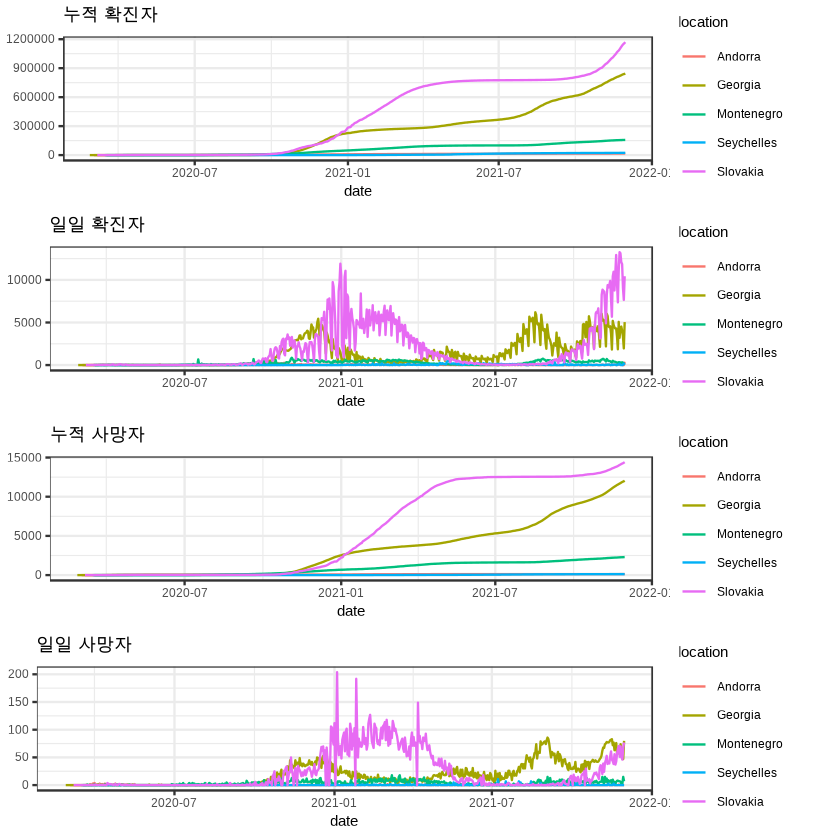

In [76]:
p1 <- data %>% filter(location %in% top5$location) %>%
    ggplot(aes(date, total_cases)) + geom_line(aes(col = location)) +
    ggtitle("누적 확진자") + theme(axis.title.y = element_blank())

gridExtra::grid.arrange(grobs = list(p1, p2, p3 ,p4), nrow = 4)

### 2-2 코로나 위험지수를 직접 만들고 그 위험지수에 대한 설명을 적고 위험지수가 높은 국가들 10개를 선정해서 시각화

- 양성률 : 확진자 총합 / 총 검사 (총 검사 < 확진자 총합 일시, 양성률은 1)
- 사망률 : 사망자 총합 / 확진자 총합
- 확진자 비율 
- 백신 접종률 : 백신 총합 / 인구 총합

위험지수 = 양성률 + 사망률 + 확진자 비율 - 백신 접종률

In [13]:
a <- data %>% filter(date == max(date)) %>%
    select(location, total_cases, total_deaths, population)

In [14]:
b <- data %>% group_by(location) %>%
    summarise(total_tests = sum(new_tests)) %>%
    filter(location %in% a$location) %>% select(-location)

In [15]:
c <- data %>% group_by(location) %>%
    summarise(total_vacc = sum(new_vaccinations)) %>%
    filter(location %in% a$location) %>% select(-location)

In [16]:
data25 <- a %>% cbind(b) %>% cbind(c)

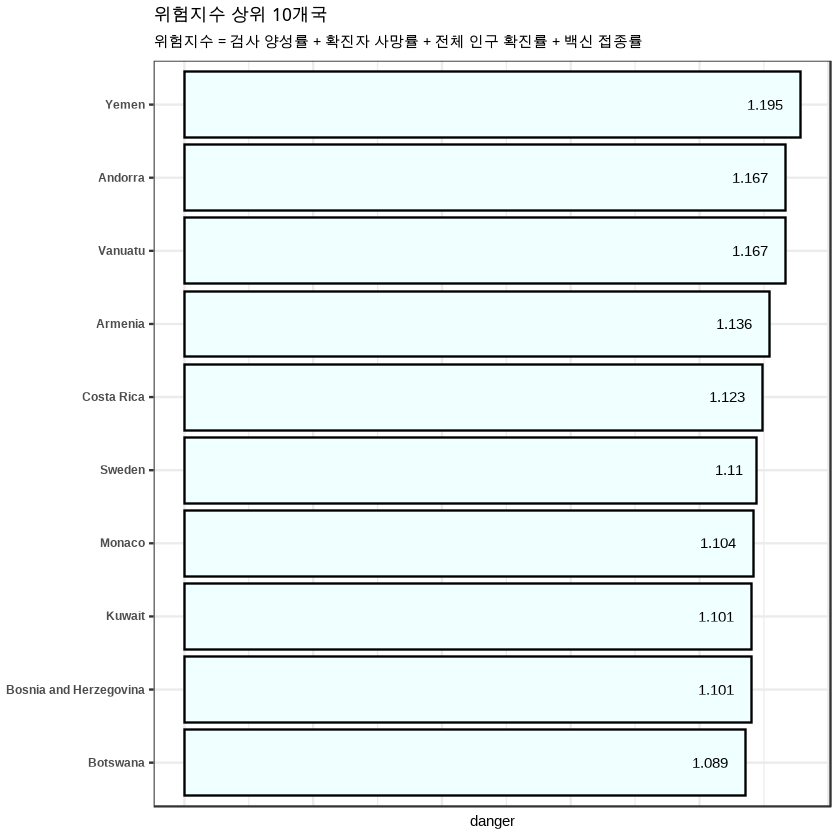

In [17]:
data25 %>% 
    mutate(rat2 = total_deaths / total_cases,
           rat3 = total_cases / population,
           rat4 = total_vacc / population,
           rat1 = total_cases / total_tests) %>% 
    mutate(rat1 = ifelse(rat1 > 0, 1, rat1)) %>%
    mutate(danger = rat1 + rat2 + rat3 - rat4) %>% 
    arrange(-danger) %>% head(10) %>%
    ggplot(aes(danger, fct_reorder(location, danger))) + 
    geom_col(fill = "azure", col = "black") +
    geom_text(aes(label = paste0(round(danger, 3))), hjust = 1.5) + 
    ggtitle("위험지수 상위 10개국", 
             subtitle = "위험지수 = 검사 양성률 + 확진자 사망률 + 전체 인구 확진률 + 백신 접종률") +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_text(face = "bold"),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank())

### 2-3 한국의 코로나 신규 확진자 예측해라(선형 시계열모델 + 비선형시계열 각각 한개씩 만들어라)

In [20]:
korea <- data %>% filter(location == "South Korea")

In [ ]:
korea %>% ggplot(aes(date, day_cases)) + geom_line()

In [ ]:
Linear = lm(day_cases ~ date, data = korea)
Quadratic = lm(day_cases ~ poly(date, 2), data = korea)
Cubic = lm(day_cases ~ poly(date, 3), data = korea)
Gam = gam(day_cases ~ s(date), data = korea)

# 3번
설문조사 데이터      
데이터 출처 : 자체 제작    
데이터 경로 : /kaggle/input/adp-kr-p3/problem3.csv 

데이터 설명 : A ~ D까지의 그룹에게 각각 같은 설문조사를 하여 1-1,1-2,1-3...5-1,5-4 인 설문지를 푼 것이다. 문항은 영역별로 나뉘어 있고, 영역은 크게 5개이다(1~5)    
각 영역의 세부문항은 4개씩 존재한다 (1-1,1-2,1-3,1-4 ~) 이 때 중간에 반대 문항이 들어가 있다. 예를 들어 1-1 문제가 "나는 시간약속을 잘 지킨다."라는 문제라면 1-3의 문제는 "나는 시간약속을 잘 지키지 않는다." 라는 역문제로 구성 되어있다. 각 영역의 3번문항의 1번문항의 역문제이다. 
모든 답변은 5점 척도이다. 문제를 풀기전 모든 역문항의 경우 점수를 변환(6점을 빼서) 작업이 필요하다

In [89]:
data3 <- read.csv("problem3.csv")
dim(data3)
sum(is.na(data3))

[1] 1000   22

[1] 0

In [90]:
table(data3$group)


  A   B   C   D 
250 250 250 250 

### 3-1 역문항을 변환 한 후 각 그룹`(A~D)`의 영역`(Q1~Q5)`별 응답의 평균, 표준편차, 왜도, 첨도를 구하라. (각 통계량 별로 4x5 dataframe 생성)

In [91]:
rev <- (data3 %>% select(colnames(data3)[colnames(data3) %>% str_detect(".3")]) - 6 )

In [92]:
data31 <- data3 %>% select(-colnames(data3)[colnames(data3) %>% str_detect(".3")]) %>% 
    cbind(rev) %>% select(colnames(data3))

In [126]:
q1 <- colnames(data3)[colnames(data3) %>% str_detect("Q1")]
q2 <- colnames(data3)[colnames(data3) %>% str_detect("Q2")]
q3 <- colnames(data3)[colnames(data3) %>% str_detect("Q3")]
q4 <- colnames(data3)[colnames(data3) %>% str_detect("Q4")]
q5 <- colnames(data3)[colnames(data3) %>% str_detect("Q5")]

In [130]:
data31$Q1 <- data31 %>% select(all_of(q1)) %>% rowSums() 
data31$Q2 <- data31 %>% select(all_of(q2)) %>% rowSums() 
data31$Q3 <- data31 %>% select(all_of(q3)) %>% rowSums() 
data31$Q4 <- data31 %>% select(all_of(q4)) %>% rowSums() 
data31$Q5 <- data31 %>% select(all_of(q5)) %>% rowSums() 

In [154]:
t1 <- data31 %>% select(group, Q1, Q2, Q3, Q4, Q5) %>% 
    group_by(group) %>% 
    summarise(q1 = mean(Q1),
              q2 = mean(Q2),
              q3 = mean(Q3),
              q4 = mean(Q4))

In [155]:
t2 <- data31 %>% select(group, Q1, Q2, Q3, Q4, Q5) %>% 
    group_by(group) %>% 
    summarise(q1 = sd(Q1),
              q2 = sd(Q2),
              q3 = sd(Q3),
              q4 = sd(Q4)) 

In [156]:
library(moments) # 왜도 (0보다 크면 왼쪽으로 치우침)
t3 <- data31 %>% select(group, Q1, Q2, Q3, Q4, Q5) %>% 
    group_by(group) %>% 
    summarise(q1 = skewness(Q1),
              q2 = skewness(Q2),
              q3 = skewness(Q3),
              q4 = skewness(Q4)) 

In [157]:
# 첨도 (3보다 작으면 정규분포보다 완만)
t4 <- data31 %>% select(group, Q1, Q2, Q3, Q4, Q5) %>% 
    group_by(group) %>% 
    summarise(q1 = kurtosis(Q1),
              q2 = kurtosis(Q2),
              q3 = kurtosis(Q3),
              q4 = kurtosis(Q4))

### 3-2 그룹별로 Q1-1문항의 차이가 존재하는지 anova분석을 시행하라

In [149]:
data32 <- data31 %>% select(group, Q1.1)

In [152]:
aov(Q1.1 ~ group, data32) %>% summary

             Df Sum Sq Mean Sq F value Pr(>F)
group         3    7.8   2.593   1.538  0.203
Residuals   996 1679.7   1.687               

- 귀무가설 : 그룹별로 Q1-1문항의 차이가 없다
- P-value > 0.05 => 귀무가설 기각 불가 => 그룹별로 Q1-1문항의 차이가 없다

### 3-3 탐색적 요인분석을 수행하고 결과를 시각화 하라

In [190]:
data32 <- data31 %>% mutate(sums = data31[, 23:27] %>% rowSums())

- 그룹별 점수분포

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



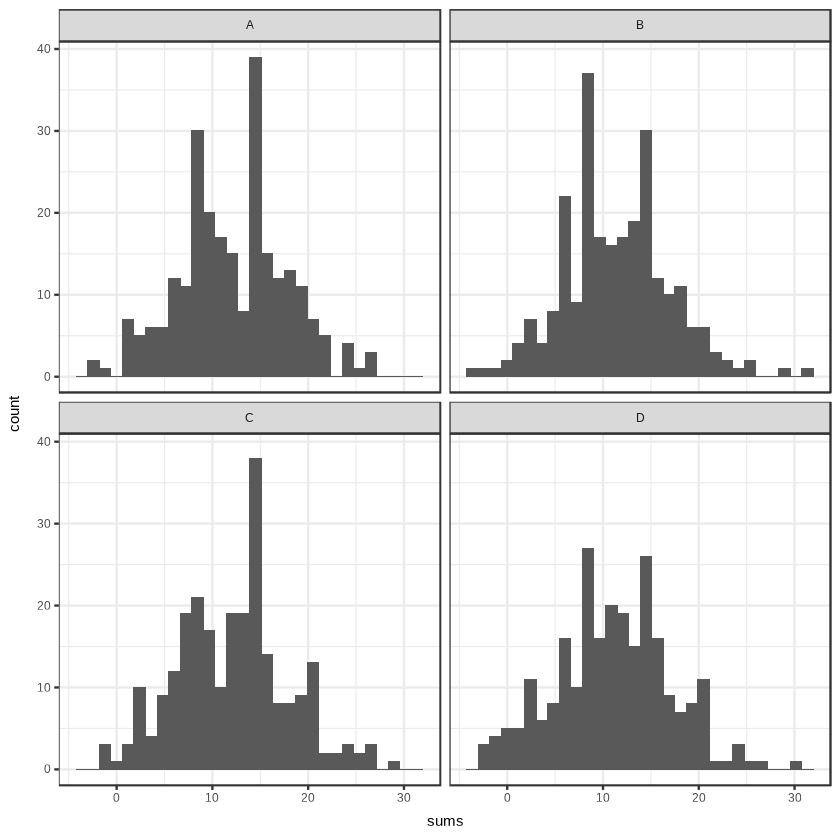

In [192]:
data32 %>% ggplot(aes(sums)) + geom_histogram() + facet_wrap(~ group)

- 전체 점수 분포

In [189]:
# data32 %>% ggplot(aes(sums)) + geom_histogram()

- 문제별 점수 분포

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



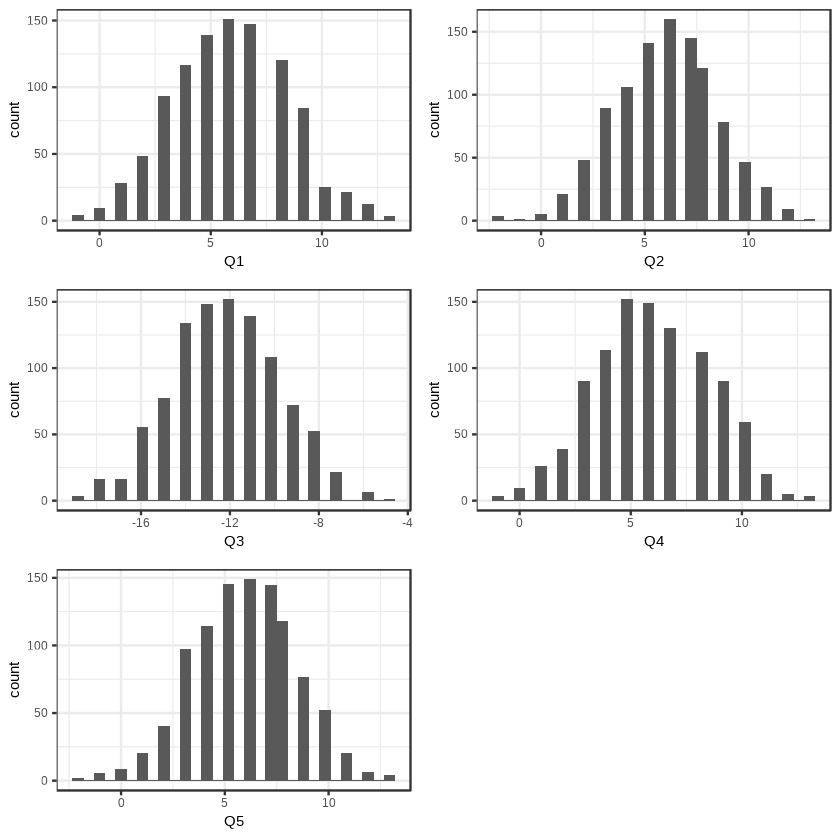

In [170]:
p1 <- data31 %>% select(group, Q1, Q2, Q3, Q4, Q5) %>% 
    ggplot() + geom_histogram(aes(Q1)) 

gridExtra::grid.arrange(grobs = list(p1, p2, p3, p4, p5), nrow = 3)

- 그룹, 문제별 점수 boxplot

In [ ]:
p1 <- data31 %>% select(group, Q1, Q2, Q3, Q4, Q5) %>%
    ggplot(aes(group, Q1)) + geom_boxplot(aes(fill = group))

gridExtra::grid.arrange(grobs = list(p1, p2, p3, p4, p5), nrow = 3)